# Defining Parameters

* **Data**: Notes - All

In [1]:
scoring_metric = 'f1_weighted'
max_iter_log = 500
max_features = 3000
svd_features = 900

#Randomized Search Metric
n_iter_search = 25

# Library Calls

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import feather
import nltk
import re
import string
import sklearn
import matplotlib.pyplot as plt

from scipy.stats import randint as sp_randint
from sklearn.decomposition import TruncatedSVD
from nltk.tokenize import sent_tokenize
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

from sklearn.model_selection import GridSearchCV, RandomizedSearchCV,  cross_val_score, cross_validate

from sklearn.svm import SVC, OneClassSVM 
from sklearn.ensemble import IsolationForest

from sklearn.metrics import classification_report, roc_curve, roc_auc_score
from sklearn.metrics import accuracy_score,precision_recall_fscore_support
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score, balanced_accuracy_score
from sklearn.metrics import confusion_matrix

# Random State
rng = np.random.RandomState(5590)
solver_log = 'saga'

# Data Import and Processing
## !!!One Data Frame Import Must Be Commented Out!!!!

In [3]:
df_all = None
df_ds = None

In [4]:
# All Available Notes
df_all = pd.read_csv('./data/text_processed_all.csv.gz', compression='gzip', low_memory=False)

# Dishcharge Summary Notes Onlly
#df_ds = pd.read_csv('./data/text_processed_discharge_summary.csv.gz', compression='gzip', low_memory=False)

# Define Data Frame

Here we do a check to see which data frame we are analyzing, All Notes or Discharge Notes

In [5]:
if df_all is not None:
    df = df_all
else:
    df = df_ds
      
# Convert HADMID to String
df.hadm_id = df.hadm_id.astype('int64').astype(str)

# Convert Readmit_30 to Int
df.readmit_30 = df.readmit_30.astype('int')

# Functions

## Modified Tokenizer
Define a modified tokenizer function. This function will remove numbers and characters, as well as set all words to lower case.

In [6]:
def tokenize_note_events(text):
    #create a list of all characters and numbers
    num_puct_list = string.punctuation+'0123456789'
    
    # Create a dictionary aligning each numeric and chcarter to a space
    t = str.maketrans(dict.fromkeys(num_puct_list, " "))
    
    # Convert Text to lower case and apply dictionary
    text = text.lower().translate(t)
    
    #tokenize
    tokens = nltk.word_tokenize(text)
    return tokens

## Custom Stop Words
Define custom stop words

In [7]:
stop_words = ['the','and','to','of','was','with','a','on','in','for','name',
 'is','patient','s','he','at','as','or','one','she','his','her','am', 
 'were','you','pt','pm','by','be','had','your','this','date', 'from',
 'there','an','that','p','are','have','has','h','but','o', 
 'namepattern','which','every','also', 'w', 'd', 'c', 'l', 
 'q', 'r', 'x', 't', 'm']

## Text Processing Function with Truncated SVD
The following function performs all of the prec-processing steps, using sub-sampling to balance the data. The function tokenizes the text using 1-grams and 2-grams. The function returns a processed predictor dataframe for the training and validation data, as well as the target variable for the training and validation data.

In [8]:
def text_processing(df):
    # Clean the Entire Data Set of numbers, characters, carriage returns, and new lines
    df.text = df.text.fillna(' ')
    df.text = df.text.str.replace('\n',' ')
    df.text = df.text.str.replace('\r',' ')
    
    # Split into Train, Valid and Test
    ## Shuffle
    df = df.sample(n = len(df), random_state = rng)
    df = df.reset_index(drop = True)
    
    ## Extract Data for Test and Valid Sampling
    df_v_te = df.sample(frac=0.40, random_state = rng)
    
    ## Test Sample
    df_te = df_v_te.sample(frac = 0.5, random_state = rng)
    
    ## Valid Sample
    df_v = df_v_te.drop(df_te.index)

    ## Training Sample
    df_tr = df.drop(df_v_te.index)
    
    # Split the training data into normal and outlier data.
    df_tr_normal = df_tr[df_tr['readmit_30']==0]
    df_tr_outlier = df_tr[df_tr['readmit_30']==1]
    
    
    # Initialize Vectorizer and SVD
    ## Use Modified Tokenizer, Set number of n-grams, use custom stop words
    vect = TfidfVectorizer(max_features = max_features, 
                           tokenizer = tokenize_note_events, 
                           ngram_range = (1,2),
                           stop_words=stop_words
                          )

    # Transform Text
    # Fit Vectorizer on Training Data
    vect.fit(df_tr.text.values)

    # Transform the text into vectors.
    x_tr_all_tf = vect.transform(df_tr.text.values)
    x_tr_normal_tf = vect.transform(df_tr_normal.text.values)
    x_tr_outlier_tf = vect.transform(df_tr_outlier.text.values)
    x_v_tf = vect.transform(df_v.text.values)
    x_te_tf  = vect.transform(df_te.text.values)

    # Define Target Variables
    y_tr_all = df_tr.readmit_30
    y_tr_normal = df_tr_normal.readmit_30
    y_tr_outlier = df_tr_outlier.readmit_30
    y_v = df_v.readmit_30
    y_te = df_te.readmit_30
    
    return x_tr_all_tf, x_tr_normal_tf, x_tr_outlier_tf, x_v_tf, x_te_tf, y_tr_all, y_tr_normal, x_tr_outlier_tf, y_v, y_te

## Truncated SVD

In [9]:
def trunc_svd(x_tr_all, x_tr_normal, x_tr_outlier, x_v, x_te, n):
    svd = TruncatedSVD(n_components = n, n_iter = 7, random_state = rng)
    
    # Fit SVD on Training Data
    svd.fit(x_tr_all)
    
    # Transform Sparse Matrices
    x_tr_all_svd = svd.transform(x_tr_all)
    x_tr_normal_svd = svd.transform(x_tr_normal)
    x_tr_outlier_svd = svd.transform(x_tr_outlier)
    x_v_svd = svd.transform(x_v)
    x_te_svd  = svd.transform(x_te)
    
    return x_tr_all_svd, x_tr_normal_svd, x_tr_outlier_svd, x_v_svd, x_te_svd

## Model Output

### Scoring Metrics
The following functions calculate the scoring metrics the models will be evlauted on.

In [10]:
def calc_specificity(y_actual, y_pred, thresh):
    # calculates specificity
    return sum((y_pred < thresh) & (y_actual == 0)) /sum(y_actual ==0)

def calc_prevalence(y_actual):
    # calculates prevalence
    return sum((y_actual == 1)) /len(y_actual)

### Scoring Output
The following code generates the visual output of the scoring metrics.

In [11]:
def roc_curve_plot(y_tr, y_tr_preds, y_v, y_v_preds):
    
    fpr_tr, tpr_tr, thresholds_tr = roc_curve(y_tr, y_tr_preds)
    fpr_v, tpr_v, thresholds_v = roc_curve(y_v, y_v_preds)
    
    plt.plot(fpr_tr, tpr_tr,'r-', label = 'Train AUC: %.2f'%roc_auc_score(y_tr, y_tr_preds))
    plt.plot(fpr_v, tpr_v,'b-',label = 'Valid AUC: %.2f'%roc_auc_score(y_v, y_v_preds))
    plt.plot([0,1],[0,1],'-k')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()
    plt.show()

### Confusion Matrix

In [12]:
def pretty_cm(y_pred, y_truth, labels):
    '''
    'Pretty' implementation of a confusion matrix with some evaluation statistics.
    
    Input:
    y_pred - object with class predictions from the model
    y_truth - object with actual classes
    labels - list containing label names
    '''
    
    cm = confusion_matrix(y_truth, y_pred)
    ax= plt.subplot()
    sns.heatmap(cm, annot=True, fmt="d", linewidths=.5, square = True, cmap = 'BuGn_r')
    ax.set_xlabel('Predicted label')
    ax.set_ylabel('Actual label')
    ax.set_title('Confusion Matrix', size = 15) 
    ax.xaxis.set_ticklabels(labels)
    ax.yaxis.set_ticklabels(labels)
    
    print('#######################')
    print('Evaluation metrics ####')
    print('#######################')
    print('Accuracy: {:.3f}'.format(accuracy_score(y_truth, y_pred)))
    print('AUC Score: {:.3f}'.format(roc_auc_score(y_truth, y_pred)))
    print('Precision: {:.3f}'.format(precision_score(y_truth, y_pred)))
    print('Precision Weighted: {:.3f}'.format(precision_score(y_truth, y_pred, average = 'weighted')))
    print('Recall: {:.3f}'.format(recall_score(y_truth, y_pred)))
    print('Recall Weighted: {:.3f}'.format(recall_score(y_truth, y_pred, average = 'weighted')))
    print('F1: {:.3f}'.format(f1_score(y_truth, y_pred)))
    print('F1 Weighted: {:.3f}'.format(f1_score(y_truth, y_pred, average = 'weighted')))
    print('Prevelance: {:.3f}'.format(calc_prevalence(y_truth)))

## Model Execution

The following function trains a default model to the training data and generates training and validation scores.

In [13]:
def train_model_default(clf, x_tr, x_v):
    
    clf.fit(x_tr, y_tr)

    y_tr_preds = clf.predict_proba(x_tr)[:,1]
    y_v_preds = clf.predict_proba(x_v)[:,1]

    roc_curve_plot(y_tr, y_tr_preds, y_v, y_v_preds)

The following function takes in the optimized model and generates training and validation scores


In [14]:
def opt_model_scoring(clf, x_tr, x_v):
    
    y_tr_preds = clf.predict_proba(x_tr)[:,1]
    y_v_preds = clf.predict_proba(x_v)[:,1]

    roc_curve_plot(y_tr, y_tr_preds, y_v, y_v_preds)

The following function runs the gridsearchcv

## Data Processing

Split the Data into train, validation, and test data sets.

In [15]:
df = df.sample(frac = 0.05, random_state = rng)

x_tr_all_tf, x_tr_normal_tf, x_tr_outlier_tf, x_v_tf, x_te_tf, y_tr_all, y_tr_normal, y_tr_outlier_tf, y_v, y_te = text_processing(df)

Split the training data into normal and outlier data.

In [16]:
x_tr_normal_tf.shape[0]

1268

In [17]:
# Proportion of Outliers
outlier_prop = x_tr_outlier_tf.shape[0] / x_tr_normal_tf.shape[0]

### Dimension Reduction

In [18]:
x_tr_all, x_tr_normal, x_tr_outlier, x_v, x_te = trunc_svd(x_tr_all_tf, x_tr_normal_tf, x_tr_outlier_tf, x_v_tf, x_te_tf, svd_features)

## Modeling - Default Settings

### One Class SVM

One class SVM trains the model on only normal (non-readmit) data. Then predicts on full data.

In [19]:
clf = OneClassSVM(kernel='rbf', nu=outlier_prop, gamma = 0.000001) 

In [20]:
clf.fit(x_tr_normal)

OneClassSVM(cache_size=200, coef0=0.0, degree=3, gamma=1e-06, kernel='rbf',
            max_iter=-1, nu=0.06782334384858044, random_state=None,
            shrinking=True, tol=0.001, verbose=False)

#######################
Evaluation metrics ####
#######################
Accuracy: 0.470
AUC Score: 0.484
Precision: 0.060
Precision Weighted: 0.877
Recall: 0.500
Recall Weighted: 0.470
F1: 0.107
F1 Weighted: 0.591
Prevelance: 0.064


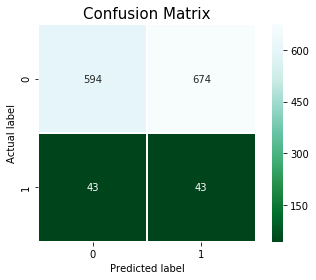

In [21]:
# Training
x = x_tr_all
y = y_tr_all
y_pred = clf.predict(x)
y_pred = [1 if x == -1 else 0 for x in y_pred]
y_pred = pd.Series(y_pred)
pretty_cm(y_pred, y, [0, 1])

#######################
Evaluation metrics ####
#######################
Accuracy: 0.851
AUC Score: 0.533
Precision: 0.106
Precision Weighted: 0.883
Recall: 0.167
Recall Weighted: 0.851
F1: 0.130
F1 Weighted: 0.866
Prevelance: 0.067


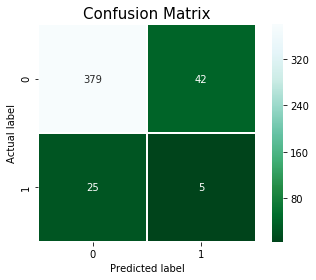

In [22]:
# Validation
x = x_v
y = y_v
y_pred = clf.predict(x)
y_pred = [1 if x == -1 else 0 for x in y_pred]
y_pred = pd.Series(y_pred)
pretty_cm(y_pred, y, [0, 1])

### Isolation Forest

#### Fit on No-Outlier Data

In [23]:
iforest = IsolationForest(max_samples=100, random_state=rng, contamination= outlier_prop,  behaviour="new", verbose = 1)

iforest.fit(x_tr_normal)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.0s finished


IsolationForest(behaviour='new', bootstrap=False,
                contamination=0.06782334384858044, max_features=1.0,
                max_samples=100, n_estimators=100, n_jobs=None,
                random_state=<mtrand.RandomState object at 0x000001CD82E7B798>,
                verbose=1, warm_start=False)

#######################
Evaluation metrics ####
#######################
Accuracy: 0.877
AUC Score: 0.495
Precision: 0.055
Precision Weighted: 0.880
Recall: 0.058
Recall Weighted: 0.877
F1: 0.056
F1 Weighted: 0.878
Prevelance: 0.064


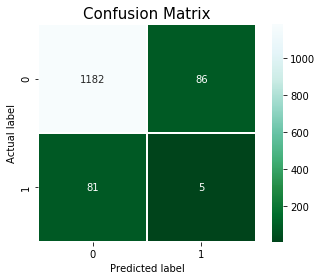

In [24]:
# Training
x = x_tr_all
y = y_tr_all
clf = iforest
y_pred = clf.predict(x)
y_pred = [1 if x == -1 else 0 for x in y_pred]
y_pred = pd.Series(y_pred)
pretty_cm(y_pred, y, [0, 1])

#######################
Evaluation metrics ####
#######################
Accuracy: 0.885
AUC Score: 0.505
Precision: 0.077
Precision Weighted: 0.877
Recall: 0.067
Recall Weighted: 0.885
F1: 0.071
F1 Weighted: 0.881
Prevelance: 0.067


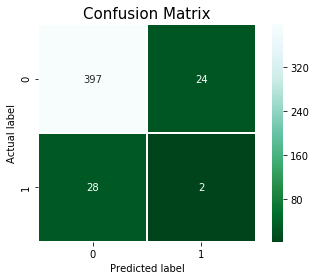

In [25]:
# Validation
x = x_v
y = y_v
clf = iforest
y_pred = clf.predict(x)
y_pred = [1 if x == -1 else 0 for x in y_pred]
y_pred = pd.Series(y_pred)

pretty_cm(y_pred, y, [0, 1])

#### Fit on All Data

In [26]:
iforest = IsolationForest(max_samples=100, random_state=rng, contamination= outlier_prop,  behaviour="new", verbose = 1)

iforest.fit(x_tr_all)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.1s finished


IsolationForest(behaviour='new', bootstrap=False,
                contamination=0.06782334384858044, max_features=1.0,
                max_samples=100, n_estimators=100, n_jobs=None,
                random_state=<mtrand.RandomState object at 0x000001CD82E7B798>,
                verbose=1, warm_start=False)

#######################
Evaluation metrics ####
#######################
Accuracy: 0.871
AUC Score: 0.476
Precision: 0.022
Precision Weighted: 0.876
Recall: 0.023
Recall Weighted: 0.871
F1: 0.022
F1 Weighted: 0.874
Prevelance: 0.064


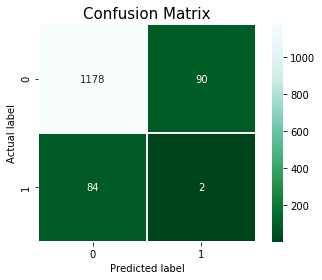

In [27]:
# Training
x = x_tr_all
y = y_tr_all
clf = iforest
y_pred = clf.predict(x)
y_pred = [1 if x == -1 else 0 for x in y_pred]
y_pred = pd.Series(y_pred)
pretty_cm(y_pred, y, [0, 1])

#######################
Evaluation metrics ####
#######################
Accuracy: 0.891
AUC Score: 0.524
Precision: 0.120
Precision Weighted: 0.882
Recall: 0.100
Recall Weighted: 0.891
F1: 0.109
F1 Weighted: 0.887
Prevelance: 0.067


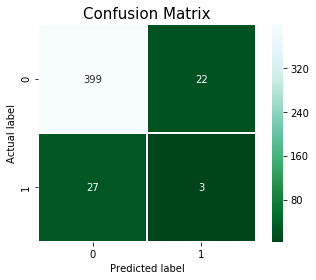

In [28]:
# Validation
x = x_v
y = y_v
clf = iforest
y_pred = clf.predict(x)
y_pred = [1 if x == -1 else 0 for x in y_pred]
y_pred = pd.Series(y_pred)

pretty_cm(y_pred, y, [0, 1])

### Visual Method
The following method is based on generating a histogram of scores and seeing if you can visually identify a cluster of outliers.

https://www.depends-on-the-definition.com/detecting-network-attacks-with-isolation-forests/

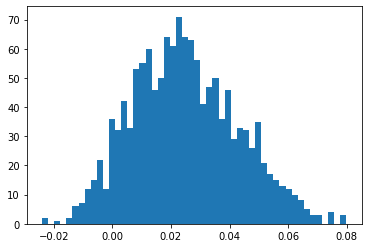

In [29]:
#Validation
scores = iforest.decision_function(x_tr_all)
plt.figure(figsize=(6, 4))
plt.hist(scores, bins=50);

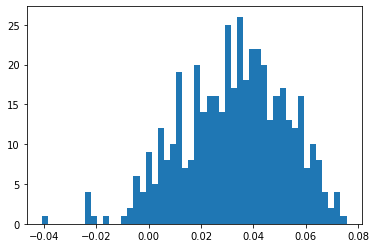

In [30]:
#Validation
scores = iforest.decision_function(x_v)
plt.figure(figsize=(6, 4))
plt.hist(scores, bins=50);

## Parameter Optimization

### One Class SVM

It is difficult and complicated to run a grid search for One Class SVM. The following code box is meant for manual adjustments of gamma.

#######################
Evaluation metrics ####
#######################
Accuracy: 0.745
AUC Score: 0.523
Precision: 0.079
Precision Weighted: 0.880
Recall: 0.267
Recall Weighted: 0.745
F1: 0.122
F1 Weighted: 0.802
Prevelance: 0.067


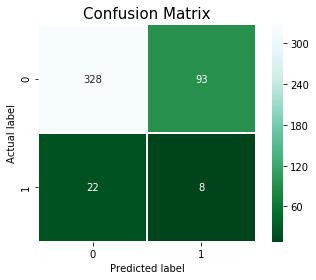

In [68]:
svm = OneClassSVM(kernel='rbf', nu=outlier_prop, gamma = 1e-7) 

svm.fit(x_tr_normal)

# Validation
x = x_v
y = y_v
y_pred = svm.predict(x)
y_pred = [1 if x == -1 else 0 for x in y_pred]
y_pred = pd.Series(y_pred)
pretty_cm(y_pred, y, [0, 1])

The following method allows for One Class SVM to be looped over hyperparameters. 
Method based on:
https://stackoverflow.com/questions/44698928/is-there-a-way-to-perform-grid-search-hyper-parameter-optimization-on-one-class

In [32]:
# gammas = np.logspace(-9, 3, 13)
# nus = np.linspace(0.01, 0.1, 5)

# clf = OneClassSVM()

# results = []

# train_x = x_tr_normal
# valid_x = x_v


# for gamma in gammas:
#     for nu in nus:
#         clf.set_params(gamma=gamma, nu=nu)

#         clf.fit(train_x)

#         y_pred = clf.predict(valid_x)
        
#         y_pred = [1 if x == -1 else 0 for x in y_pred]

#         if 1. in y_pred:  # Check if at least 1 review is predicted to be in the class
#             results.append(((gamma, nu), (accuracy_score(y_true, y_pred),
#                                               precision_score(y_true, y_pred),
#                                               recall_score(y_true, y_pred),
#                                               f1_score(y_true, y_pred),
#                                               roc_auc_score(y_true, y_pred),
#                                               ))
#                                )

### Isoaltion Forest

#### AUC Score
Best Tuning Metric so far.

In [33]:
# Model
clf = IsolationForest(random_state=rng,  behaviour="new")

# Parameters
param_dist = {'n_estimators':sp_randint(100,400),
                   'max_samples': sp_randint(100,500), 
                   'contamination': [0.01, 0.05, 0.1, 0.2], 
                   'max_features': sp_randint(1,20), 
                   'bootstrap': [True, False]}

# Scorer
scorer = 'roc_auc'

# Number of Search
n_iter_search = n_iter_search

# Radomizer
random_if_estimator = RandomizedSearchCV(clf, 
                                       param_dist,
                                       n_iter = n_iter_search,
                                       scoring = scorer, 
                                       cv = 5,
                                       n_jobs = 4,
                                       verbose = 1,
                                       return_train_score = True)

In [34]:
random_if_estimator.fit(x_tr_all, y_tr_all)

Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   12.9s
[Parallel(n_jobs=4)]: Done 125 out of 125 | elapsed:   36.7s finished


RandomizedSearchCV(cv=5, error_score='raise-deprecating',
                   estimator=IsolationForest(behaviour='new', bootstrap=False,
                                             contamination='legacy',
                                             max_features=1.0,
                                             max_samples='auto',
                                             n_estimators=100, n_jobs=None,
                                             random_state=<mtrand.RandomState object at 0x000001CD82E7B798>,
                                             verbose=0, warm_start=False),
                   iid='warn', n_iter=25, n_jobs=4,
                   param_distributions={'bootstra...
                                        'max_features': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000001CD847FF630>,
                                        'max_samples': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000001CD847FF908>,
                                      

In [35]:
print('Scorer')
print(random_if_estimator.scorer_)
print("")
print("Best Score")
print(random_if_estimator.best_score_)
print("")
print("Best Score Parameters")
print(random_if_estimator.best_params_)

Scorer
make_scorer(roc_auc_score, needs_threshold=True)

Best Score
0.5920271030870886

Best Score Parameters
{'bootstrap': False, 'contamination': 0.1, 'max_features': 19, 'max_samples': 413, 'n_estimators': 381}


In [36]:
clf_auc = random_if_estimator.best_estimator_
clf = clf_auc

#######################
Evaluation metrics ####
#######################
Accuracy: 0.851
AUC Score: 0.508
Precision: 0.074
Precision Weighted: 0.883
Recall: 0.116
Recall Weighted: 0.851
F1: 0.090
F1 Weighted: 0.866
Prevelance: 0.064


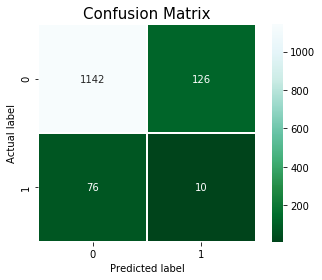

In [37]:
# Training
x = x_tr_all
y = y_tr_all
y_pred = clf.predict(x)
y_pred = [1 if x == -1 else 0 for x in y_pred]
y_pred = pd.Series(y_pred)
pretty_cm(y_pred, y, [0, 1])

#######################
Evaluation metrics ####
#######################
Accuracy: 0.876
AUC Score: 0.516
Precision: 0.094
Precision Weighted: 0.880
Recall: 0.100
Recall Weighted: 0.876
F1: 0.097
F1 Weighted: 0.878
Prevelance: 0.067


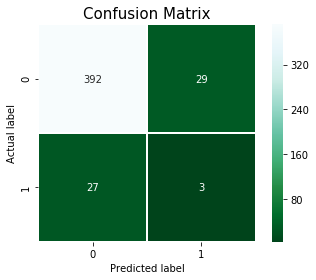

In [38]:
# Validation
x = x_v
y = y_v
y_pred = clf.predict(x)
y_pred = [1 if x == -1 else 0 for x in y_pred]
y_pred = pd.Series(y_pred)

pretty_cm(y_pred, y, [0, 1])

### F1 Weighted
Ran once and performed poorly. Do not run again.

In [39]:
# Model
clf = IsolationForest(random_state=rng,  behaviour="new")

# Parameters
param_dist = {'n_estimators':sp_randint(100,400),
                   'max_samples': sp_randint(100,500), 
                   'contamination': [0.01, 0.05, 0.1, 0.2], 
                   'max_features': sp_randint(1,20), 
                   'bootstrap': [True, False]}

# Scorer
scorer = 'f1_weighted'

# Number of Search
n_iter_search = n_iter_search

# Radomizer
random_if_estimator = RandomizedSearchCV(clf, 
                                       param_dist,
                                       n_iter = n_iter_search,
                                       scoring = scorer, 
                                       cv=5,
                                       n_jobs = 4,
                                       verbose = 1,
                                       return_train_score = True)

In [40]:
random_if_estimator.fit(x_tr_all, y_tr_all)

Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   12.9s
[Parallel(n_jobs=4)]: Done 125 out of 125 | elapsed:   35.0s finished


RandomizedSearchCV(cv=5, error_score='raise-deprecating',
                   estimator=IsolationForest(behaviour='new', bootstrap=False,
                                             contamination='legacy',
                                             max_features=1.0,
                                             max_samples='auto',
                                             n_estimators=100, n_jobs=None,
                                             random_state=<mtrand.RandomState object at 0x000001CD82E7B798>,
                                             verbose=0, warm_start=False),
                   iid='warn', n_iter=25, n_jobs=4,
                   param_distributions={'bootstra...
                                        'max_features': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000001CE32ED69E8>,
                                        'max_samples': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000001CE32ED6B70>,
                                      

In [41]:
print('Scorer')
print(random_if_estimator.scorer_)
print("")
print("Best Score")
print(random_if_estimator.best_score_)
print("")
print("Best Score Parameters")
print(random_if_estimator.best_params_)

Scorer
make_scorer(f1_score, pos_label=None, average=weighted)

Best Score
0.008991102229014879

Best Score Parameters
{'bootstrap': True, 'contamination': 0.2, 'max_features': 19, 'max_samples': 394, 'n_estimators': 399}


In [42]:
clf_f1 = random_if_estimator.best_estimator_
clf = clf_f1

#######################
Evaluation metrics ####
#######################
Accuracy: 0.760
AUC Score: 0.492
Precision: 0.059
Precision Weighted: 0.880
Recall: 0.186
Recall Weighted: 0.760
F1: 0.090
F1 Weighted: 0.813
Prevelance: 0.064


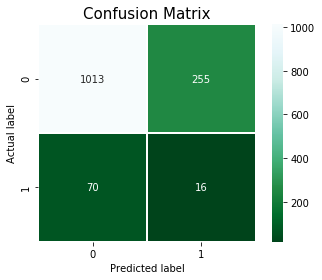

In [43]:
# Training
x = x_tr_all
y = y_tr_all
y_pred = clf.predict(x)
y_pred = [1 if x == -1 else 0 for x in y_pred]
y_pred = pd.Series(y_pred)
pretty_cm(y_pred, y, [0, 1])

#######################
Evaluation metrics ####
#######################
Accuracy: 0.838
AUC Score: 0.542
Precision: 0.109
Precision Weighted: 0.884
Recall: 0.200
Recall Weighted: 0.838
F1: 0.141
F1 Weighted: 0.859
Prevelance: 0.067


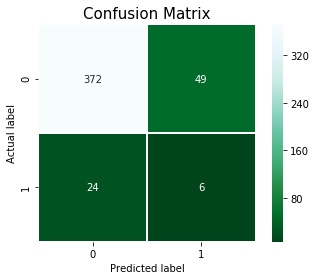

In [44]:
# Validatin
x = x_v
y = y_v
y_pred = clf.predict(x)
y_pred = [1 if x == -1 else 0 for x in y_pred]
y_pred = pd.Series(y_pred)
pretty_cm(y_pred, y, [0, 1])

# Test Set Scoring

## General Function

In [45]:
def test_score(clf, x):
    
    print("Detailed classification report:")
    print()
    print("The model is trained and tuned on the training and validation sets..")
    print("The scores are computed on the test set.")
    print()
    y_true, y_pred = y_te, clf.predict(x)
    y_pred = [1 if x == -1 else 0 for x in y_pred]
    print(classification_report(y_true, y_pred, digits = 3))
    print()
    
    prevalence_te = '%.3f' %calc_prevalence(y_true)
    auc_score_te = '%.3f' %roc_auc_score(y_true, y_pred)
    print('AUC Score: ', auc_score_te)
    print('Positive Target Prevalence: ', prevalence_te)
    

In [46]:
def test_score_cv(clf, x):
    scoring = ['roc_auc', 'accuracy', 'balanced_accuracy', 'precision', 'recall', 'f1']
    
    results = cross_validate(estimator = clf,
                                          X = x,
                                          y = y_te,
                                          cv = 5,
                                          scoring = scoring)
    for metric_name in results.keys():
        average_score = np.average(results[metric_name])
        print('%s : %.3f' % (metric_name, average_score))
    
    prevalence_te = '%.3f' %calc_prevalence(y_te)
    print('positive target prevalence: ', prevalence_te)

## One Class SVM

#######################
Evaluation metrics ####
#######################
Accuracy: 0.738
AUC Score: 0.518
Precision: 0.066
Precision Weighted: 0.894
Recall: 0.269
Recall Weighted: 0.738
F1: 0.106
F1 Weighted: 0.804
Prevelance: 0.058


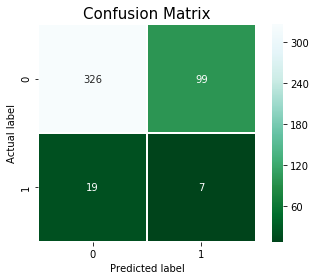

In [69]:
# Test
x = x_te
y = y_te
y_pred = svm.predict(x)
y_pred = [1 if x == -1 else 0 for x in y_pred]
y_pred = pd.Series(y_pred)
pretty_cm(y_pred, y, [0, 1])

## Isolation Forest

#### AUC

#######################
Evaluation metrics ####
#######################
Accuracy: 0.871
AUC Score: 0.498
Precision: 0.056
Precision Weighted: 0.891
Recall: 0.077
Recall Weighted: 0.871
F1: 0.065
F1 Weighted: 0.881
Prevelance: 0.058


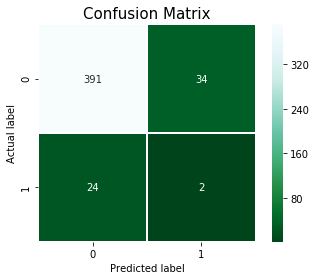

In [48]:
clf = clf_auc

# Test
x = x_te
y = y_te
y_pred = clf.predict(x)
y_pred = [1 if x == -1 else 0 for x in y_pred]
y_pred = pd.Series(y_pred)
pretty_cm(y_pred, y, [0, 1])

#### F1 Weighted

#######################
Evaluation metrics ####
#######################
Accuracy: 0.845
AUC Score: 0.484
Precision: 0.042
Precision Weighted: 0.889
Recall: 0.077
Recall Weighted: 0.845
F1: 0.054
F1 Weighted: 0.866
Prevelance: 0.058


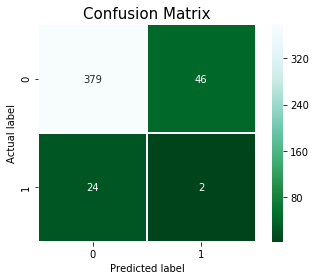

In [49]:
clf = clf_f1

# Test
x = x_te
y = y_te
y_pred = clf.predict(x)
y_pred = [1 if x == -1 else 0 for x in y_pred]
y_pred = pd.Series(y_pred)
pretty_cm(y_pred, y, [0, 1])